# Machine Learning for AI detection: Exploratory Data Analysis

In the previous notebook we cleaned and compiled the raw data into a single dataset consisting of over 24000 samples. We are now ready to explore the dataset using natural language processing (NLP) tools. Let's import the data:

In [1]:
import pandas as pd

samples = pd.read_csv('https://raw.githubusercontent.com/tommyliphysics/tommyli-ml/main/ai_detector/notebooks/samples.csv')
samples

,text,source,topic,TTV split,label
0,I can't honestly believe that this is a sequel...,imdb,movie review,2.0,0
1,LL Cool J performed much better in this movie ...,imdb,movie review,0.0,0
2,It would be unwise to judge that that either n...,imdb,movie review,-1.0,0
3,20th Century Fox's ROAD HOUSE 1948) is not onl...,imdb,movie review,3.0,0
4,"I am a fan of Jess Franco's bizarre style, and...",imdb,movie review,-1.0,0
...,...,...,...,...,...
24175,The Louisville Cardinals men's soccer team is ...,wikipedia by GPT,Louisville Cardinals men's soccer,4.0,1
24176,"KFC Yum! Center, also known as the Yum! Center...",wikipedia by GPT,KFC Yum! Center,4.0,1
24177,The 2020–21 Louisville Cardinals men's basketb...,wikipedia by GPT,2020–21 Louisville Cardinals men's basketball ...,4.0,1
24178,Conte Forum is a multi-purpose indoor arena lo...,wikipedia by GPT,Conte Forum,4.0,1


## Tokenisation

Our first step in NLP will be to tokenise the data which, involves splitting a sample of text into individual units, which may either be whole words (word tokenization), or commonly occurring parts of words (subword tokenization). We can train a tokenizer from scratch from the data, or using a pre-trained tokenizer from a large language model (LLM). We will explore a number of different options: in addition to word tokenization, we will also look at subword tokenisation methods: byte pair encoding (BPE), wordpiece, sentencepiece, and the pre-trained tokenizers from three LLMs, GPT-2, Bert and Deberta.

In [2]:
from transformers import PreTrainedTokenizerFast
from tokenizers import Tokenizer
from tokenizers.models import BPE,WordPiece
from tokenizers.trainers import BpeTrainer,WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace

In [3]:
BPE_tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
BPE_tokenizer.pre_tokenizer = Whitespace()
BPE_tokenizer.train_from_iterator(samples['text'], trainer=trainer)
BPE_tokenizer.save("BPE.json")
tokenizer_BPE_trained = PreTrainedTokenizerFast(tokenizer_file="BPE.json")

In [4]:
# create and train wordpiece tokenizer

wordpiece_tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
trainer = WordPieceTrainer(special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"])
wordpiece_tokenizer.pre_tokenizer = Whitespace()
wordpiece_tokenizer.train_from_iterator(samples['text'], trainer=trainer)
wordpiece_tokenizer.save("wordpiece.json")
tokenizer_wordpiece_trained = Tokenizer.from_file("wordpiece.json")

In [5]:
import sentencepiece as spm

corpus_text = '\n\n'.join(samples['text'].tolist())
with open("corpus.txt", "w") as f:
    f.write(corpus_text)

spm.SentencePieceTrainer.Train('--input=corpus.txt --model_prefix=sentencepiece')
tokenizer_sentencepiece_trained = spm.SentencePieceProcessor()
tokenizer_sentencepiece_trained.Load('sentencepiece.model')

True

In [6]:
# import pre-trained tokenizers from LLMs

from transformers import GPT2Tokenizer, BertTokenizer, DebertaV2Tokenizer

tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2', max_length = 2048)
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-cased', max_length = 2048)
tokenizer_deberta_v3 = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-base', max_length = 2048)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

In [7]:
from nltk import word_tokenize

def tokenizer(text, name, cased=True):
    if cased is False:
        text = text.lower()
    if name == 'BPE':
        return [str(t) for t in tokenizer_BPE_trained(text)['input_ids']]
    elif name == 'wordpiece':
        return [str(t) for t in tokenizer_wordpiece_trained.encode(text).ids]
    elif name == 'sentencepiece':
        return [str(t) for t in tokenizer_sentencepiece_trained.encode_as_ids(text)]
    elif name == 'gpt-2':
        return [str(t) for t in tokenizer_gpt2(text)['input_ids']]
    elif name == 'bert':
        return [str(t) for t in tokenizer_bert(text)['input_ids']]
    elif name == 'deberta-v3':
        return [str(t) for t in tokenizer_deberta_v3(text)['input_ids']]
    elif name == 'word':
        return word_tokenize(text)
    else:
        print('Tokenizer name not recognized.')

def tokenizer_decode(tokenized, name):
    if name == 'BPE':
        return [tokenizer_BPE_trained.decode([int(t)]) for t in tokenized]
    elif name == 'wordpiece':
        return [tokenizer_wordpiece_trained.decode([int(t)]) for t in tokenized]
    elif name == 'sentencepiece':
        return [tokenizer_sentencepiece_trained.decode([int(t)]) for t in tokenized]
    elif name == 'gpt-2':
        return [tokenizer_gpt2.decode([int(t)]) for t in tokenized]
    elif name == 'bert':
        return [tokenizer_bert.decode([int(t)]) for t in tokenized]
    elif name == 'deberta-v3':
        return [tokenizer_deberta_v3.decode([int(t)]) for t in tokenized]
    else:
        print('Tokenizer name not recognized.')

We can test our tokenisers on a few lines from Wind Rose's 2019 hit single 'Diggy diggy hole.' We'll first encode the data, then decode it to see how the tokenisers split words into subword tokens:

In [14]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
%%time

strg = "I am a dwarf and I'm digging a hole. Diggy diggy hole, diggy diggy hole..."
tokenizer_list = ['BPE', 'wordpiece', 'sentencepiece', 'gpt-2', 'bert', 'deberta-v3', 'word']

print(f'Text: {strg}')

for tokenizer_name in tokenizer_list:
    tokenized = tokenizer(strg, tokenizer_name)
    print(f'\tTokenized ({tokenizer_name}): {tokenized}')
    if tokenizer_name != 'word':
        print(f'\tDecoded: {tokenizer_decode(tokenized, tokenizer_name)}')
    print("\n")

Text: I am a dwarf and I'm digging a hole. Diggy diggy hole, diggy diggy hole...
	Tokenized (BPE): ['45', '1969', '69', '19209', '74', '1937', '45', '11', '81', '23714', '69', '9903', '18', '10940', '3715', '3897', '3715', '9903', '16', '3897', '3715', '3897', '3715', '9903', '3190']
	Decoded: ['I', 'am', 'a', 'dwar', 'f', 'and', 'I', "'", 'm', 'digging', 'a', 'hole', '.', 'Dig', 'gy', 'dig', 'gy', 'hole', ',', 'dig', 'gy', 'dig', 'gy', 'hole', '...']


	Tokenized (wordpiece): ['45', '3680', '69', '25843', '3323', '45', '11', '81', '26590', '69', '12401', '18', '12900', '4381', '5778', '4381', '12401', '16', '5778', '4381', '5778', '4381', '12401', '4595']
	Decoded: ['I', 'am', 'a', 'dwarf', 'and', 'I', "'", 'm', 'digging', 'a', 'hole', '.', 'Dig', '##gy', 'dig', '##gy', 'hole', ',', 'dig', '##gy', 'dig', '##gy', 'hole', '...']


	Tokenized (sentencepiece): ['12', '243', '10', '798', '2769', '161', '7', '12', '13', '35', '590', '109', '109', '15', '10', '14', '4099', '6', '1186', '109'

We can now use our trained tokenisers to tokenise the samples:

In [16]:
%%time

from tqdm import tqdm

def tokenizer_key(name, cased):
    return f"{name}-{'cased' if cased else 'uncased'}"

for cased in [True, False]:
    for name in tqdm(tokenizer_list):
        samples[tokenizer_key(name, cased)] = samples['text'].apply(lambda x: tokenizer(x, name, cased))

samples

100%|██████████| 7/7 [08:50<00:00, 75.77s/it]


CPU times: user 17min 13s, sys: 12.6 s, total: 17min 25s
Wall time: 17min 23s


,text,source,topic,TTV split,label,BPE-cased,wordpiece-cased,sentencepiece-cased,gpt-2-cased,bert-cased,deberta-v3-cased,word-cased,BPE-uncased,wordpiece-uncased,sentencepiece-uncased,gpt-2-uncased,bert-uncased,deberta-v3-uncased,word-uncased
0,I can't honestly believe that this is a sequel...,imdb,movie review,2.0,0,"[45, 2121, 11, 88, 5805, 3305, 1976, 2041, 193...","[45, 3520, 11, 88, 7426, 4802, 3365, 3425, 335...","[12, 60, 13, 18, 2709, 491, 17, 31, 16, 10, 23...","[40, 460, 470, 12698, 1975, 326, 428, 318, 257...","[101, 146, 1169, 112, 189, 12051, 2059, 1115, ...","[1, 273, 295, 280, 297, 6137, 770, 272, 291, 2...","[I, ca, n't, honestly, believe, that, this, is...","[77, 2121, 11, 88, 5805, 3305, 1976, 2041, 193...","[77, 3520, 11, 88, 7426, 4802, 3365, 3425, 335...","[207, 60, 13, 18, 2709, 491, 17, 31, 16, 10, 2...","[72, 460, 470, 12698, 1975, 326, 428, 318, 257...","[101, 178, 1169, 112, 189, 12051, 2059, 1115, ...","[1, 584, 295, 280, 297, 6137, 770, 272, 291, 2...","[i, ca, n't, honestly, believe, that, this, is..."
1,LL Cool J performed much better in this movie ...,imdb,movie review,0.0,0,"[11047, 18707, 46, 8133, 2549, 3094, 1926, 204...","[48, 1965, 26434, 46, 9916, 4007, 4575, 3330, ...","[574, 337, 679, 273, 1091, 4905, 211, 507, 11,...","[3069, 15226, 449, 6157, 881, 1365, 287, 428, ...","[101, 12427, 13297, 147, 1982, 1277, 1618, 110...","[1, 21965, 6906, 851, 2264, 400, 493, 267, 291...","[LL, Cool, J, performed, much, better, in, thi...","[2282, 6672, 78, 8133, 2549, 3094, 1926, 2041,...","[5020, 8437, 78, 9916, 4007, 4575, 3330, 3425,...","[14, 151, 3743, 2326, 4905, 211, 507, 11, 31, ...","[297, 3608, 474, 6157, 881, 1365, 287, 428, 38...","[101, 1325, 4348, 179, 1982, 1277, 1618, 1107,...","[1, 507, 436, 1570, 4402, 2264, 400, 493, 267,...","[ll, cool, j, performed, much, better, in, thi..."
2,It would be unwise to judge that that either n...,imdb,movie review,-1.0,0,"[2127, 2227, 1959, 1970, 4990, 1942, 10459, 19...","[3510, 3635, 3347, 6402, 3802, 3328, 9952, 336...","[63, 100, 42, 223, 3742, 9, 3416, 17, 17, 1016...","[1026, 561, 307, 555, 3083, 284, 5052, 326, 32...","[101, 1135, 1156, 1129, 8362, 15868, 1106, 394...","[1, 325, 338, 282, 44923, 264, 3128, 272, 272,...","[It, would, be, unwise, to, judge, that, that,...","[1941, 2227, 1959, 1970, 4990, 1942, 10459, 19...","[3355, 3635, 3347, 6402, 3802, 3328, 9952, 336...","[22, 100, 42, 223, 3742, 9, 3416, 17, 17, 1016...","[270, 561, 307, 555, 3083, 284, 5052, 326, 326...","[101, 1122, 1156, 1129, 8362, 15868, 1106, 394...","[1, 278, 338, 282, 44923, 264, 3128, 272, 272,...","[it, would, be, unwise, to, judge, that, that,..."
3,20th Century Fox's ROAD HOUSE 1948) is not onl...,imdb,movie review,3.0,0,"[4814, 16776, 10186, 11, 87, 8927, 5764, 11302...","[6390, 19154, 12318, 11, 87, 54, 1959, 14682, ...","[742, 91, 197, 304, 189, 45, 6250, 13, 4, 14, ...","[1238, 400, 13641, 5426, 338, 15107, 2885, 465...","[101, 3116, 5944, 3977, 112, 188, 155, 23579, ...","[1, 602, 474, 7178, 4224, 280, 268, 41119, 306...","[20th, Century, Fox, 's, ROAD, HOUSE, 1948, ),...","[4814, 2869, 21194, 11, 87, 4177, 2899, 10875,...","[6390, 4340, 25638, 11, 87, 7492, 4458, 12774,...","[742, 91, 413, 276, 2931, 13, 4, 2863, 483, 66...","[1238, 400, 4289, 21831, 338, 2975, 2156, 2179...","[101, 3116, 1432, 17594, 112, 188, 1812, 1402,...","[1, 602, 474, 1880, 16123, 280, 268, 1212, 669...","[20th, century, fox, 's, road, house, 1948, ),..."
4,"I am a fan of Jess Franco's bizarre style, and...",imdb,movie review,-1.0,0,"[45, 1969, 69, 4202, 1946, 11825, 14273, 11, 8...","[45, 3680, 69, 6069, 3327, 13596, 17012, 11, 8...","[12, 243, 10, 1298, 8, 2810, 4, 4, 4932, 335, ...","[40, 716, 257, 4336, 286, 12707, 22198, 338, 1...","[101, 146, 1821, 170, 5442, 1104, 12419, 9063,...","[1, 273, 481, 266, 2066, 265, 19554, 18813, 28...","[I, am, a, fan, of, Jess, Franco, 's, bizarre,...","[77, 1969, 69, 4202, 1946, 78, 2026, 17649, 21...","[77, 3680, 69, 6069, 3327, 11106, 12010, 342

## Visualising the tokeniser vocabularies

We are now ready to explore the vocabulary. Using the tokenized texts, we will perform a count of each token and plot their frequencies:

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import numpy as np

import gc

def get_term_frequencies(texts, vocabulary=None):
    if vocabulary is None:
        tf_vectorizer = TfidfVectorizer(preprocessor= lambda x:x, use_idf=False, norm='l1', tokenizer=lambda x:x, token_pattern=None, lowercase=False)
        vectorized = tf_vectorizer.fit_transform(texts).tocsr()
        vocabulary = tf_vectorizer.get_feature_names_out()
        vocab_size = len(vocabulary)
        print(f"Created new TF vectorizer with vocabulary size = {vocab_size}")

        mean_term_frequencies = np.ravel(vectorized.mean(axis=0))
        del(tf_vectorizer)
        gc.collect()

        term_indices_ranked_by_frequency_asc = np.argsort(mean_term_frequencies)
        term_indices_ranked_by_frequency = [term_indices_ranked_by_frequency_asc[vocab_size - 1 - i] for i in range(vocab_size)]
        terms_ranked_by_frequency = [vocabulary[term_indices_ranked_by_frequency[i]] for i in range(vocab_size)]

        return mean_term_frequencies, vocabulary, term_indices_ranked_by_frequency, terms_ranked_by_frequency, vocab_size

    else:
        tf_vectorizer = TfidfVectorizer(preprocessor= lambda x:x, use_idf=False, norm='l1', tokenizer=lambda x:x, token_pattern=None, vocabulary=vocabulary, lowercase=False)
        vectorized = tf_vectorizer.fit_transform(texts).tocsr()

        mean_term_frequencies = np.ravel(vectorized.mean(axis=0))
        del(tf_vectorizer)
        gc.collect()

        return mean_term_frequencies

Created new TF vectorizer with vocabulary size = 21790
Created new TF vectorizer with vocabulary size = 21647
Created new TF vectorizer with vocabulary size = 6599
Created new TF vectorizer with vocabulary size = 31728
Created new TF vectorizer with vocabulary size = 19570
Created new TF vectorizer with vocabulary size = 58776
Created new TF vectorizer with vocabulary size = 162626
Created new TF vectorizer with vocabulary size = 29553
Created new TF vectorizer with vocabulary size = 28295
Created new TF vectorizer with vocabulary size = 7998
Created new TF vectorizer with vocabulary size = 46832
Created new TF vectorizer with vocabulary size = 27749
Created new TF vectorizer with vocabulary size = 93777
Created new TF vectorizer with vocabulary size = 184698


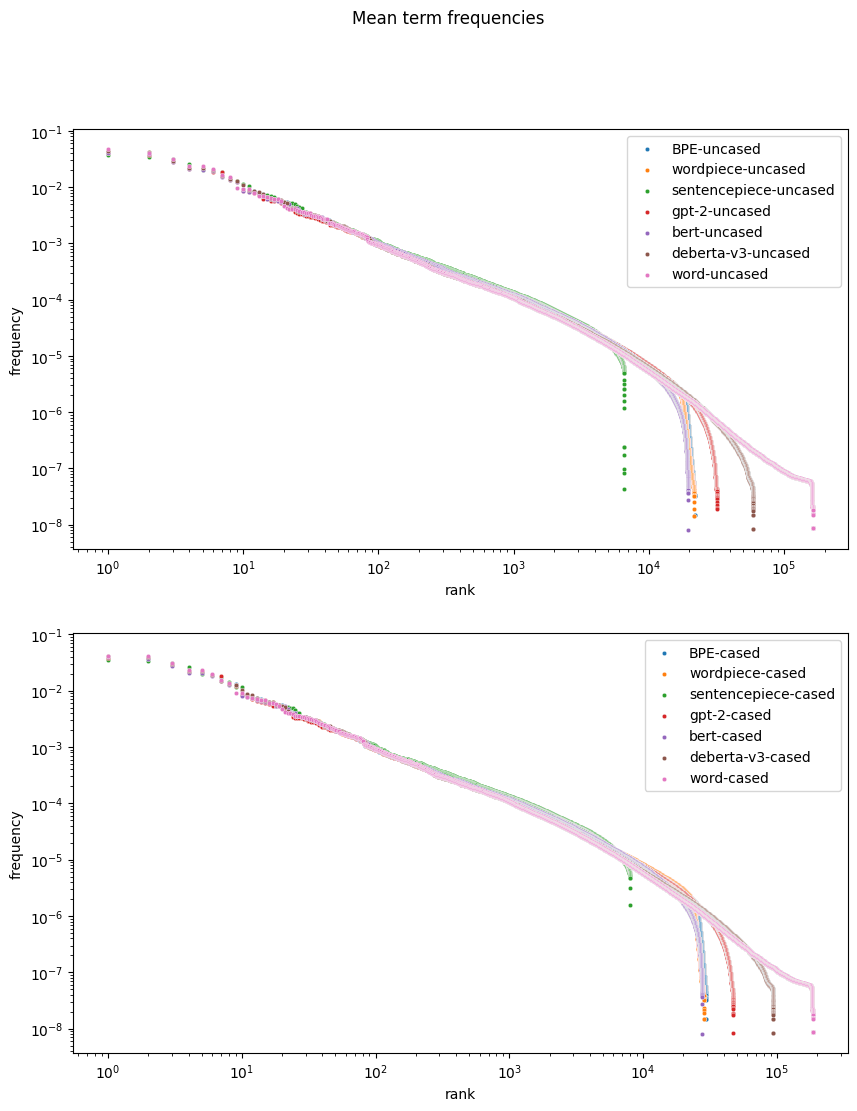

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,1, figsize=(10,12))

for cased in (0,1):
    for name in tokenizer_list:
        mean_term_frequencies, vocabulary, term_indices_ranked_by_frequency, _, vocab_size = get_term_frequencies(samples[tokenizer_key(name, cased)])
        X = np.arange(len(mean_term_frequencies))
        Y = [mean_term_frequencies[term_indices_ranked_by_frequency[i]] for i in range(vocab_size)]
        sns.scatterplot(x=X, y=Y, ax = axes[cased], label=tokenizer_key(name,cased), s=10)

    axes[cased].set_xscale('log')
    axes[cased].set_yscale('log')
    axes[cased].set_xlabel('rank')
    axes[cased].set_ylabel('frequency')

fig.suptitle('Mean term frequencies')
plt.show()

In [20]:
name = 'BPE'
cased = True

term_frequencies_human, vocabulary, term_indices_ranked_by_frequency, _, vocab_size = get_term_frequencies(samples[samples['label']==0][tokenizer_key(name, cased)])
term_frequencies_AI = get_term_frequencies(samples[samples['label']==1][tokenizer_key(name, cased)], vocabulary=vocabulary)

Created new TF vectorizer with vocabulary size = 29365


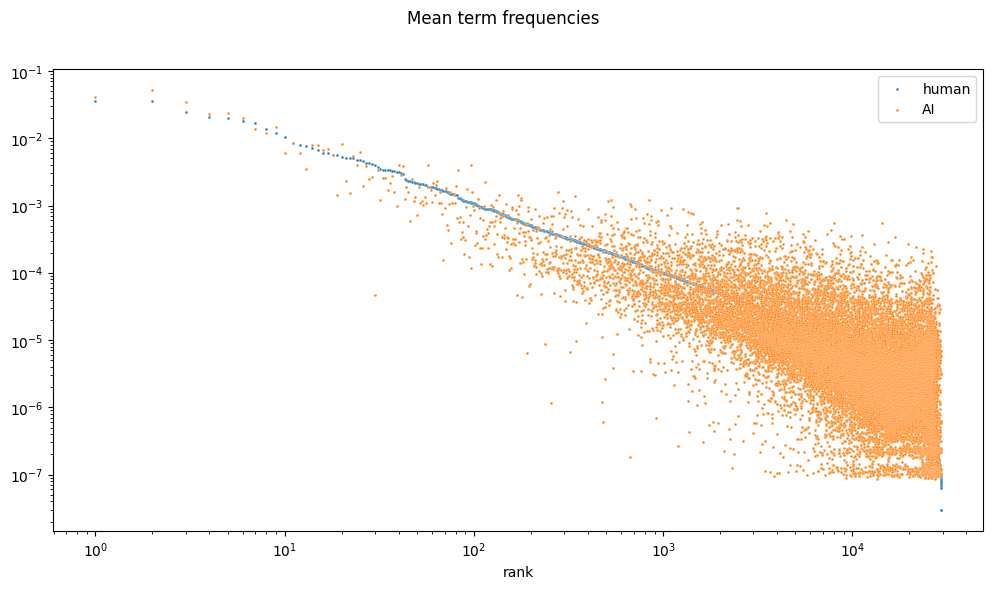

In [21]:
fig, ax = plt.subplots(figsize=(12,6))

sns.scatterplot(x=np.arange(vocab_size), y=[term_frequencies_human[term_indices_ranked_by_frequency[i]] for i in range(vocab_size)], label='human', s=4)
sns.scatterplot(x=np.arange(vocab_size), y=[term_frequencies_AI[term_indices_ranked_by_frequency[i]] for i in range(vocab_size)], label='AI', s=4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('rank')

fig.suptitle('Mean term frequencies')
plt.show()

We see a discrepancy between the mean term frequencies for the AI and human-generated texts. This discrepancy exists for the most common tokens. Let's compare them numerically.

In [22]:
token_frequency_data = pd.DataFrame()
token_frequency_data['term'] = [tokenizer_decode([vocabulary[term_indices_ranked_by_frequency[i]]], 'BPE') for i in range(vocab_size)]
token_frequency_data['frequency in human texts'] = [term_frequencies_human[term_indices_ranked_by_frequency[i]] for i in range(vocab_size)]
token_frequency_data['frequency in AI texts'] = [term_frequencies_AI[term_indices_ranked_by_frequency[i]] for i in range(vocab_size)]
token_frequency_data.head(20)

,term,frequency in human texts,frequency in AI texts
0,[the],0.037112,0.040510
1,[.],0.036304,0.041212
2,"[,]",0.035487,0.051934
3,[and],0.024748,0.034067
4,[of],0.020571,0.023177
5,[to],0.020118,0.023798
6,[a],0.018145,0.020136
7,[I],0.016761,0.013528
8,[in],0.013650,0.012158
9,['],0.012137,0.014531


We see that the mean term frequencies of the most frequent tokens, including punctuation, differ between the AI and human generated texts by approximately 10%. To see whether this is significant, we can look at how consistent the term frequencies are among the AI and human generated texts by comparing the train and test data, divided by label.

In [23]:
test = samples[samples['TTV split']==-1]
train = samples[samples['TTV split']>-1]

In [24]:
name = 'BPE'
cased = True

term_frequencies_human_train, vocabulary_human, term_indices_human, _, vocab_size_human = get_term_frequencies(train[train['label']==0][tokenizer_key(name, cased)])
term_frequencies_human_test = get_term_frequencies(test[test['label']==0][tokenizer_key(name, cased)], vocabulary=vocabulary_human)

term_frequencies_AI_train, vocabulary_AI, term_indices_AI, _, vocab_size_AI = get_term_frequencies(train[train['label']==1][tokenizer_key(name, cased)])
term_frequencies_AI_test = get_term_frequencies(test[test['label']==1][tokenizer_key(name, cased)], vocabulary=vocabulary_AI)

Created new TF vectorizer with vocabulary size = 28993
Created new TF vectorizer with vocabulary size = 26494


In [26]:
vocab_size_human

28993

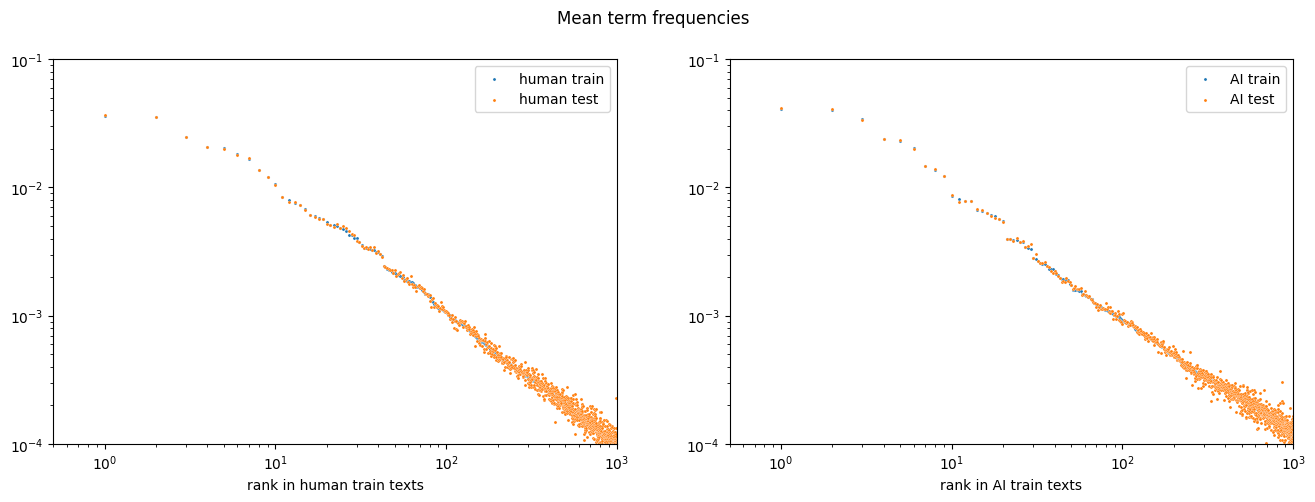

In [29]:
fig, axes = plt.subplots(1,2, figsize=(16,5))

sns.scatterplot(x=np.arange(vocab_size_human), y=[term_frequencies_human_train[term_indices_human[i]] for i in range(vocab_size_human)], ax = axes[0], label='human train', s=5)
sns.scatterplot(x=np.arange(vocab_size_human), y=[term_frequencies_human_test[term_indices_human[i]] for i in range(vocab_size_human)], ax = axes[0], label='human test', s=5)

sns.scatterplot(x=np.arange(vocab_size_AI), y=[term_frequencies_AI_train[term_indices_AI[i]] for i in range(vocab_size_AI)], ax = axes[1], label='AI train', s=5)
sns.scatterplot(x=np.arange(vocab_size_AI), y=[term_frequencies_AI_test[term_indices_AI[i]] for i in range(vocab_size_AI)], ax = axes[1], label='AI test', s=5)

for label in [0,1]:
    axes[label].set_xscale('log')
    axes[label].set_yscale('log')
    axes[label].set_xlim(0.5,1000)
    axes[label].set_ylim(1e-4,1e-1)

axes[0].set_xlabel('rank in human train texts')
axes[1].set_xlabel('rank in AI train texts')

fig.suptitle('Mean term frequencies')
plt.show()

We can see that within the individual classes, the token frequencies are very consistent up to the 1000 most frequent tokens. Thus the discrepancy between the token distributions in the human and AI texts indicates a distinguishing feature. In the next notebooks we will train neural networks to identify AI-generated texts. Rather than using the token frequencies, however, we will be using models built using the transformer architecture that were pre-trained on a large corpus of texts (billions of tokens) to perform text generation. We will re-train these large-language models on our data to perform text classification.